# Example use of the Shot class

The shot class features 
* A Dictionary / list of the signals within this shot
* Pre-processing functionality for the data signals within a shot
* Data loading of the signal data (implemented by calling the signal's getter methods)
* a Target function that give a time-base.

In this notebook we demonstrate how a shot is instantiated and how signals are specified. Then we investigate the internals of the `preprocess` method that loads the data and interpolates it on a common time-base.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from frnn_loader.backends.machine import MachineD3D
from frnn_loader.data.user_signals import fs07, ip, q95, neped
from frnn_loader.primitives.shots import Shot
from frnn_loader.utils.processing import resample_signal

import numpy as np
import matplotlib.pyplot as plt

To instantiate a shot, we only need to provide a shot number, a machine, and a list of signals.
All other information, such as `ttd` and `is_disruptive` will be filled in during pre-processing.

In [3]:
signal_list = [fs07, ip, q95, neped]
my_shot = Shot(184800, MachineD3D(), signal_list)

# List the signals that are in the shot
for s in my_shot.signals:
    print("Signal ", s, " is of type ", type(s))

Signal  filterscope fs07  is of type  <class 'frnn_loader.primitives.signal.Signal'>
Signal  plasma current  is of type  <class 'frnn_loader.primitives.signal.Signal'>
Signal  q95 safety factor  is of type  <class 'frnn_loader.primitives.signal.Signal'>
Signal  neped  is of type  <class 'frnn_loader.primitives.signal.Signal'>


We now have the shot loaded. Next we walk through the steps
in the `preprocess` member function

In [4]:
# To pre-process the shot we use the following fields of the
# configuration dict

dummy_conf = {"paths": {"data": "what_is_this", "signal_prepath": "/home/rkube/datasets/frnn/signal_data_new_2021/"}, 
              "data": {"dt": 0.01, "T_min_warn": 0.0},
              "model": {"length": 0.0}}

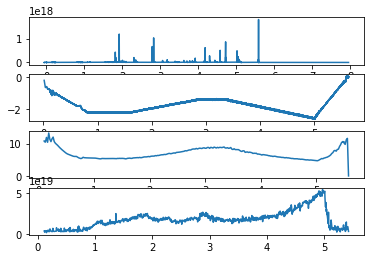

In [5]:
# The first step is to load all signals
res = my_shot._load_signal_data(dummy_conf)
fig, axs = plt.subplots(len(res))
for i in range(4):
    axs[i].plot(res[0][i], res[1][i])

As seen in the plot above, the signals do not share a time base. As a
next step we may want to sample them on a common time base. This time base can maximally cover the intersection of each individual time base. 

In [6]:
# Let's print the minimum and the maximum of the time bases we have in our shot
print("Maxima of each time base: ", [r.max() for r in res[0]])
print("Minima of each time base: ", [r.min() for r in res[0]])    
    
# # The largest minimum and smallest maximum are in the result from _load_signal_data
print(res[2], res[3])
# These will later-on define the range of the re-sampling
t_min, t_max = res[2], res[3]

Maxima of each time base:  [7.9500003, 5.63425, 5.5845, 5.42524]
Minima of each time base:  [-0.049980003, 0.012750001, 0.1, 0.110832]
0.110832 5.42524


The function `resample_signal` handles resampling on a common time-base. The shot class handles resampling like the following block:


In [7]:
signals_dict = {}
for (signal, tb, sig_data) in zip(my_shot.signals, res[0], res[1]):
    # Cut the signal to [t_min:t_max]
    good_idx = (tb >= t_min) & (tb <= t_max)
    tb_x = tb[good_idx]
    sig_x = sig_data[good_idx]
    # Interpolate on new time-base
    tb_rs, sig_rs = resample_signal(tb, sig_data, t_min, t_max, 0.01, np.float32)
    # Populate signals_dict with the re-sampled 
    signals_dict[signal] = sig_rs

#         # Why to we take only the last time-base and convert to ttd?
#         self.ttd = self.convert_to_ttd(tb_rs, conf)

And finally, we can over-plot the re-sampled signals on the original signals.

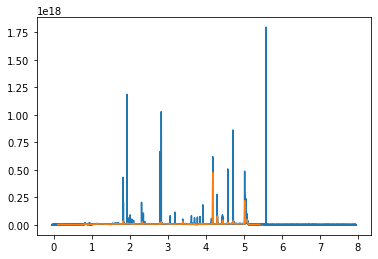

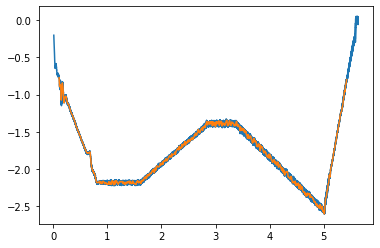

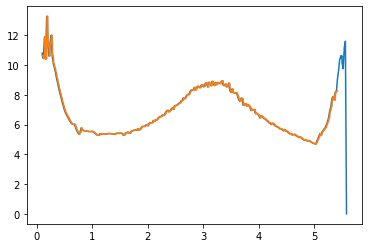

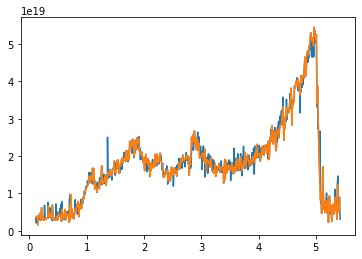

In [8]:
for i, sig in enumerate(signal_list):
    plt.figure()
    plt.plot(res[0][i], res[1][i])   
    plt.plot(tb_rs, signals_dict[sig])
